## **0.Dataset**

In [1]:
!gdown --id 1kc6XNqHZJg27KeBuoAoYj70_1rT92191

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191
From (redirected): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191&confirm=t&uuid=cf2e042c-66de-462c-a735-be9b19fc2410
To: /content/vqa_coco_dataset.zip
100% 196M/196M [00:03<00:00, 58.7MB/s]


In [2]:
!unzip -q vqa_coco_dataset.zip

## **1. Import libraries and set random seed**

In [3]:
!pip install timm==0.8.17.dev0
!pip install torchtext==0.15.1
!pip install torchvision==0.16.0
!pip install torchaudio==2.1.0
!pip install torch==2.1.0
!pip install transformers==4.27.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [4]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt
import time

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel, ViTImageProcessor
from transformers import AutoTokenizer, RobertaModel

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

### **2. Process Dataset**

In [6]:
def making_dataset(dataset_path, data):
  with open(dataset_path, 'r') as f:
    lines = f.readlines()
    for line in lines:

      temp = line.split('\t')
      qa = temp[1].split('?')

      if len(qa) == 3:
        answer = qa[2].strip()
      elif len(qa) == 2:
        answer = qa[1].strip()

      data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }

      data.append(data_sample)

  return data

In [7]:
train_data = []
val_data = []
test_data = []

train_set_path = "/content/vaq2.0.TrainImages.txt"
val_set_path = "/content/vaq2.0.DevImages.txt"
test_set_path = "/content/vaq2.0.TestImages.txt"


train_data = making_dataset(train_set_path, train_data)
val_data = making_dataset(val_set_path, val_data)
test_data = making_dataset(test_set_path, test_data)



**Example**

In [8]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

print(train_data[0])

7846
1952
2022
{'image_path': 'COCO_val2014_000000393225.jpg', 'question': 'Is this a creamy soup ?', 'answer': 'no'}


### **3. Data Preprocessing**

In [9]:
classes = set([sample['answer'] for sample in train_data])
label2idx = {
    cls_name : idx for idx, cls_name in enumerate(classes)
}
idx2label = {
    idx : cls_name for idx, cls_name in enumerate(classes)
}

print(label2idx)

{'yes': 0, 'no': 1}


### **4. Create Pytorch Dataset**

In [10]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        label2idx,
        img_feature_extractor,
        text_tokenizer,
        device,
        transforms=None,
        img_dir='val2014-resised'
    ):
        self.data = data
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_feature_extractor = img_feature_extractor
        self.text_tokenizer = text_tokenizer
        self.device = device
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.data[index]['image_path'])
        img = Image.open(img_path).convert('RGB')

        if self.transforms:
            img = self.transforms(img)

        if self.img_feature_extractor:
            img = self.img_feature_extractor(images=img, return_tensors="pt")
            img = {k: v.to(self.device).squeeze(0) for k, v in img.items()}

        question = self.data[index]['question']
        if self.text_tokenizer:
            question = self.text_tokenizer(
                question,
                padding="max_length",
                max_length=20,
                truncation=True,
                return_tensors="pt"
            )
            question = {k: v.to(self.device).squeeze(0) for k, v in question.items()}


        label = self.data[index]['answer']
        label = torch.tensor(
            self.label2idx[label],
            dtype=torch.long
        ).to(self.device)

        sample = {
            'image': img,
            'question': question,
            'label': label
        }

        return sample

**Augmentation**

In [11]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.CenterCrop(size=180),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.GaussianBlur(3),
])

In [12]:
img_feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
text_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = VQADataset(
    train_data,
    label2idx=label2idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device,
    transforms=data_transform
)
val_dataset = VQADataset(
    val_data,
    label2idx=label2idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)
test_dataset = VQADataset(
    test_data,
    label2idx=label2idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [13]:
train_batch_size = 256
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

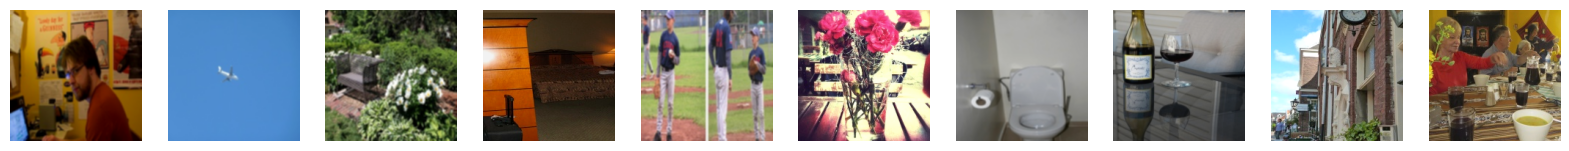

In [14]:
img_dir='val2014-resised/'
img_to_show = 10
shift = 10
test_imgs = [
    os.path.join(img_dir, sample['image_path']) for sample in train_data[shift:shift+img_to_show]
]
fig, axes = plt.subplots(nrows=1, ncols=img_to_show, figsize=(20, 4))
for ax, img_path in zip(axes, test_imgs):
    img_pil = Image.open(img_path).convert('RGB')
    preprocessed_img = data_transform(img_pil)
    ax.imshow(preprocessed_img)
    ax.axis('off')
plt.show()

## **5.Create VQA Model**

In [15]:
class VisualEncoder(nn.Module):
    def __init__(self):
        super(VisualEncoder, self).__init__()
        self.model = ViTModel.from_pretrained("google/vit-base-patch16-224")

    def forward(self, inputs):
        outputs = self.model(**inputs)

        return outputs.pooler_output

In [16]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.model = RobertaModel.from_pretrained("roberta-base")

    def forward(self, inputs):
        outputs = self.model(**inputs)

        return outputs.pooler_output

In [17]:
class Classifier(nn.Module):
    def __init__(
        self,
        hidden_size=512,
        dropout_prob=0.2,
        n_classes=2
    ):
        super(Classifier,self).__init__()
        self.fc1 = nn.Linear(768 * 2, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_size, n_classes)

    def forward(self,x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [18]:
class VQAModel(nn.Module):
    def __init__(
        self,
        visual_encoder,
        text_encoder,
        classifier
    ):
        super(VQAModel, self).__init__()
        self.visual_encoder = visual_encoder
        self.text_encoder = text_encoder
        self.classifier = classifier


    def forward(self, image, answer):
        text_out = self.text_encoder(answer)
        image_out = self.visual_encoder(image)

        x = torch.cat((image_out, text_out), dim=1)
        x = self.classifier(x)

        return x

    def freeze(self, visual=True, textual=True, clas=False):
        if visual:
            for n,p in self.visual_encoder.named_parameters():
                p.requires_grad = False
        if textual:
            for n,p in self.text_encoder.named_parameters():
                p.requires_grad = False
        if clas:
            for n,p in self.classifier.named_parameters():
                p.requires_grad = False

In [19]:
n_classes = len(classes)
hidden_size = 256
dropout_prob = 0.2

text_encoder = TextEncoder().to(device)
visual_encoder = VisualEncoder().to(device)
classifier = Classifier(
    hidden_size=hidden_size,
    dropout_prob=dropout_prob,
    n_classes=n_classes
).to(device)

model = VQAModel(
    visual_encoder=visual_encoder,
    text_encoder=text_encoder,
    classifier=classifier
).to(device)
model.freeze()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
inputs = next(iter(train_loader))

model.eval()
with torch.no_grad():
    image = inputs['image']
    question = inputs['question']
    output = model(image, question)
    print(output.shape)

torch.Size([256, 2])


### **6. Training**

In [21]:
def evaluate(model, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for idx, inputs in enumerate(dataloader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [22]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        start = time.time()
        batch_train_losses = []

        model.train()
        for idx, inputs in enumerate(train_loader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc} \t Time: {time.time() - start:.2f} seconds')

        scheduler.step()

    return train_losses, val_losses

In [23]:
lr = 1e-3
epochs = 50
scheduler_step_size = epochs * 0.8
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [24]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
)

EPOCH 1:	Train loss: 0.6957	Val loss: 0.6887	Val Acc: 0.5394467213114754 	 Time: 175.06 seconds
EPOCH 2:	Train loss: 0.6801	Val loss: 0.6861	Val Acc: 0.5486680327868853 	 Time: 176.80 seconds
EPOCH 3:	Train loss: 0.6757	Val loss: 0.6851	Val Acc: 0.5440573770491803 	 Time: 176.91 seconds
EPOCH 4:	Train loss: 0.6675	Val loss: 0.6833	Val Acc: 0.5660860655737705 	 Time: 176.56 seconds
EPOCH 5:	Train loss: 0.6577	Val loss: 0.6772	Val Acc: 0.5814549180327869 	 Time: 176.95 seconds
EPOCH 6:	Train loss: 0.6517	Val loss: 0.6780	Val Acc: 0.569672131147541 	 Time: 177.36 seconds
EPOCH 7:	Train loss: 0.6383	Val loss: 0.6900	Val Acc: 0.5660860655737705 	 Time: 177.49 seconds
EPOCH 8:	Train loss: 0.6270	Val loss: 0.6796	Val Acc: 0.5870901639344263 	 Time: 177.90 seconds
EPOCH 9:	Train loss: 0.6070	Val loss: 0.6756	Val Acc: 0.6014344262295082 	 Time: 176.10 seconds
EPOCH 10:	Train loss: 0.5851	Val loss: 0.6836	Val Acc: 0.5845286885245902 	 Time: 176.47 seconds
EPOCH 11:	Train loss: 0.5668	Val loss: 0

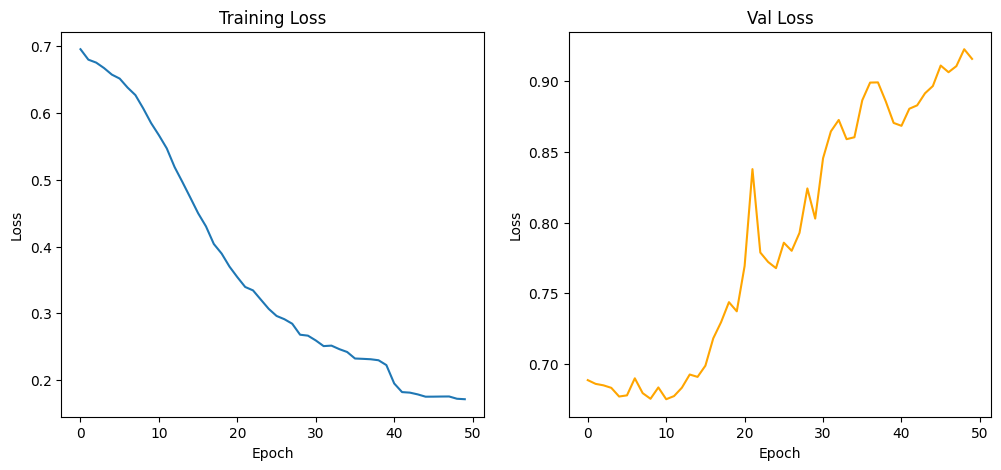

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [28]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.6670081967213115
Test accuracy:  0.636003956478734


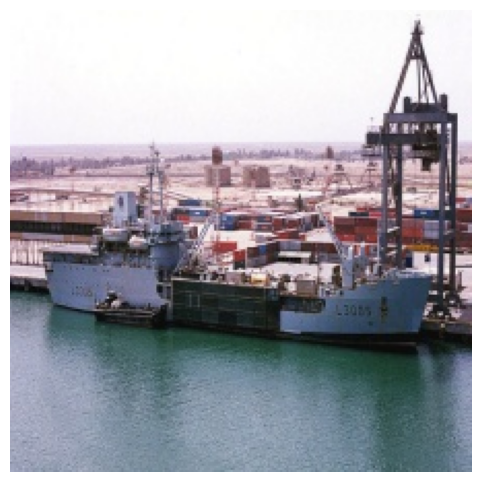

Question: Could this be leisure boat ?
Groundtruth: no
Predicted: no


In [30]:
idx = 11
img_name = test_data[idx]['image_path']
img_path = os.path.join(img_dir, img_name)
question = test_data[idx]['question']
label = test_data[idx]['answer']

question_processed = text_tokenizer(
    question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_tensors="pt"
).to(device)


img = Image.open(img_path).convert("RGB")
img_processed = img_feature_extractor(images=img, return_tensors="pt").to(device)

model.eval()
with torch.no_grad():
    output = model(img_processed, question_processed)
    pred = torch.argmax(output, dim=1).item()

plt.figure(figsize=(6, 6))
plt.imshow(np.array(img))
plt.axis('off')
plt.show()

print(f'Question: {question}')
print(f'Groundtruth: {label}')
print(f'Predicted: {idx2label[pred]}')